In [1]:
from pointnet2_benny import pointnet2_cls_ssg
from sklearn.metrics import *
from tqdm import tqdm

from final_models_explainability.get_predictions import *

In [2]:
data_path = "/uolstore/home/student_lnxhome01/sc22olj/Compsci/year3/individual-project-COMP3931/individual-project-sc22olj/scratch-disk/full-datasets/hcampus-1.5T-cohort-holdout"

In [3]:
subject_list = find_subjects_parallel(data_path)
    

Csv files: ['/uolstore/home/student_lnxhome01/sc22olj/Compsci/year3/individual-project-COMP3931/individual-project-sc22olj/scratch-disk/full-datasets/hcampus-1.5T-cohort-holdout/idaSearch_3_19_2025.csv']


In [4]:
for subject in subject_list:

    subject.data = {}

    # Group
    mapping = {
        'CN': 0,
        'MCI': 1,
    }

    # Get the value of the mapping, -1 if not found
    subject.data['research_group'] = mapping.get(subject.subject_metadata['Research Group'].iloc[0], -1)

    # Cloud
    subject.data['lhcampus_pointcloud_aligned'] = np.load(os.path.join(subject.path, 'Left-Hippocampus_aligned_cropped_mesh_downsampledcloud.npy'))

    # Volumes
    volume_col = subject.aseg_stats['Volume_mm3']
    volume_col_normalised = volume_col / volume_col.sum() * 1000
    struct_name_col = subject.aseg_stats['StructName']
    
    subject.data['volumes'] = np.array(volume_col_normalised)
    
    subject.data['struct_names'] = np.array(struct_name_col)

    # Scores
    mmse = subject.subject_metadata['MMSE Total Score'].iloc[0]
    gdscale = subject.subject_metadata['GDSCALE Total Score'].iloc[0]
    faq = subject.subject_metadata['FAQ Total Score'].iloc[0]
    npiq = subject.subject_metadata['NPI-Q Total Score'].iloc[0]

    subject.data['scores'] = [mmse, gdscale, faq, npiq]

    subject.data['score_names'] = ['MMSE Total Score', 'GDSCALE Total Score', 'FAQ Total Score', 'NPI-Q Total Score']

In [ ]:
true = []
pred_probs = []
pred_classes = []

# Run multiple times to account for randomness
for i in range(5):

    for subject in tqdm(subject_list, total=len(subject_list)):

        pred_class, output, _ = get_pointnet_prediction(subject.data['lhcampus_pointcloud_aligned'], 'opencl')

        true.append(subject.data['research_group'])
        
        pred_probs.append(output)

        pred_classes.append(pred_class)

    

100%|██████████| 35/35 [02:10<00:00,  3.73s/it]


In [ ]:
report = classification_report(true, pred_classes, target_names=['CN','MCI'])

roc_auc = roc_auc_score(true, pred_classes)

print(report)

roc_auc = roc_auc_score(true, pred_classes)

print(f"roc_auc: {roc_auc}")

fpr, tpr, thresholds = roc_curve(true, pred_probs)

plt.plot(fpr, tpr)

plt.show()

NameError: name 'classification_report' is not defined

Evaluate volumes gbdt

In [7]:
true = []
pred_probs = []
pred_classes = []

for subject in subject_list:

    pred_class, output, _ = get_volumes_prediction(subject.data['volumes'])

    true.append(subject.data['research_group'])
    
    pred_probs.append(output)

    pred_classes.append(pred_class)

In [12]:
report = classification_report(true, pred_classes, target_names=['CN', 'MCI'])

print(report)

roc_auc = roc_auc_score(true, pred_classes)

print(f"roc_auc: {roc_auc}")

fpr, tpr, thresholds = roc_curve(true, pred_probs)

plt.plot(fpr, tpr)

plt.show()

ValueError: Number of classes, 1, does not match size of target_names, 2. Try specifying the labels parameter

Evaluate scores gbdt

In [9]:
true = []
pred_probs = []
pred_classes = []

for subject in subject_list:

    pred_class, output = get_scores_prediction(subject.data['scores'])

    true.append(subject.data['research_group'])
    
    pred_probs.append(output)

    pred_classes.append(pred_class)

              precision    recall  f1-score   support

          CN       0.59      0.83      0.69        12
         MCI       0.89      0.70      0.78        23

    accuracy                           0.74        35
   macro avg       0.74      0.76      0.74        35
weighted avg       0.79      0.74      0.75        35



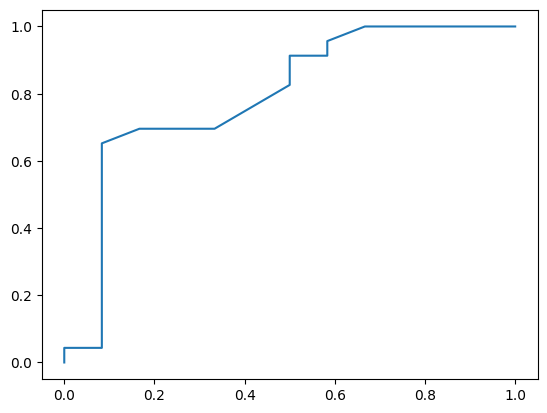

In [10]:
report = classification_report(true, pred_classes, target_names=['CN', 'MCI'])

print(report)

fpr, tpr, thresholds = roc_curve(true, pred_probs)

plt.plot(fpr, tpr)

plt.show()

Evaluate ensemble with scores

In [11]:
true = []
pred_probs = []
pred_classes = []

for subject in subject_list:

    pointnet_pred_class, pointnet_output, attributions = get_pointnet_prediction(subject.data['lhcampus_pointcloud_aligned'], 'cpu')

    volumes_pred_class, volumes_output, shap_values = get_volumes_prediction(subject.data['volumes'], subject.data['struct_names'])

    scores_pred_class, scores_output = get_scores_prediction(subject.data['scores'])

    prediction = get_ensemble_prediction_avg(pointnet_output, volumes_output, scores_output, scores=True)

    true.append(subject.data['research_group'])
    
    pred_probs.append(output)

    pred_classes.append(pred_class)

KeyboardInterrupt: 

In [ ]:
report = classification_report(true, pred_classes, target_names=['CN', 'MCI'])

print(report)

fpr, tpr, thresholds = roc_curve(true, pred_probs)

plt.plot(fpr, tpr)

plt.show()

In [ ]:
true = []
pred_probs = []
pred_classes = []

models_used = []

for subject in subject_list:

    pred_research_group, pred_class, output, model = get_ensemble_prediction_maxprob(subject.data)

    true.append(subject.data['research_group'])
    
    pred_probs.append(output)

    pred_classes.append(pred_class)

    models_used.append(model)

In [ ]:
report = classification_report(true, pred_classes, target_names=['CN', 'MCI'])

print(report)

fpr, tpr, thresholds = roc_curve(true, pred_probs)

plt.plot(fpr, tpr)

plt.show()